In [1]:
!pwd

/home/gdolle/code/G-Dolle/DIVVY_BIKE/notebooks


In [2]:
cd '/home/gdolle/code/G-Dolle/DIVVY_BIKE'

/home/gdolle/code/G-Dolle/DIVVY_BIKE


In [3]:
!pwd

/home/gdolle/code/G-Dolle/DIVVY_BIKE


In [4]:
%load_ext autoreload
%autoreload 2

In [6]:
import os
import pandas as pd
import numpy as np
import math
from datetime import date, time, datetime
import seaborn as sns

from ml_logic.data_import import get_weather_data, get_divvy_data
from ml_logic.cleaning import weather_cleaning, merge_divvy_weather, features_target
from ml_logic.preprocessor import transform_time_features, preprocess_features, target_process

from ml_logic.main import preprocess

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler

# Computing nb of departures and arrivals per hour for each station

## Nb of departures

In [8]:

quarter= os.environ.get("DIVVY_QUARTER")
year= os.environ.get("DIVVY_YEAR")


In [9]:


df = get_divvy_data(year,quarter)
df.head(2)


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,47EC0A7F82E65D52,classic_bike,2022-03-21 13:45:01,2022-03-21 13:51:18,Wabash Ave & Wacker Pl,TA1307000131,Kingsbury St & Kinzie St,KA1503000043,41.886875,-87.626030,41.889177,-87.638506,member
1,8494861979B0F477,electric_bike,2022-03-16 09:37:16,2022-03-16 09:43:34,Michigan Ave & Oak St,13042,Orleans St & Chestnut St (NEXT Apts),620,41.900998,-87.623752,41.898203,-87.637536,member


In [10]:
df.start_station_name.value_counts()

Kingsbury St & Kinzie St                        4315
Streeter Dr & Grand Ave                         3757
University Ave & 57th St                        3595
Ellis Ave & 60th St                             3581
Clark St & Elm St                               3453
                                                ... 
Tripp Ave & 15th St                                1
Carpenter St & 63rd St                             1
Seeley Ave & Garfield Blvd                         1
Troy Ave & 27th St                                 1
Pawel Bialowas - Test- PBSC charging station       1
Name: start_station_name, Length: 847, dtype: int64

In [11]:

df['started_at']=pd.to_datetime(df['started_at'])
df['ended_at']=pd.to_datetime(df['ended_at'])
df['hourly_data_started'] = df.started_at.dt.round('60min')
df['hourly_data_ended'] = df.ended_at.dt.round('60min')


In [90]:

df_departures=df[[
                 "start_station_name",
                 "start_station_id",
                 "hourly_data_started"	]]

df_departures=df_departures.rename(columns={'hourly_data_started':'hourly_data',
                                            "start_station_name":"station_name",
                                            "start_station_id": "station_id"})

df_departures.head(2)

,station_name,station_id,hourly_data,lat,lng
0,Wabash Ave & Wacker Pl,TA1307000131,2022-03-21 14:00:00,41.886875,-87.626030
1,Michigan Ave & Oak St,13042,2022-03-16 10:00:00,41.900998,-87.623752


In [91]:
df_departures["nb_departures"]=1

In [92]:

df_dep_agg=df_departures.groupby(by=["station_name",
                                        "station_id",
                                        'hourly_data']).count().reset_index()
df_dep_agg.head(10)


,station_name,station_id,hourly_data,lat,lng,nb_departures
0,2112 W Peterson Ave,KA1504000155,2022-01-01 21:00:00,41.991172,-87.683598,1
1,2112 W Peterson Ave,KA1504000155,2022-01-03 18:00:00,41.991181,-87.683610,1
2,2112 W Peterson Ave,KA1504000155,2022-01-04 11:00:00,41.991178,-87.683593,1
3,2112 W Peterson Ave,KA1504000155,2022-01-04 18:00:00,41.991174,-87.683614,1
4,2112 W Peterson Ave,KA1504000155,2022-01-10 09:00:00,41.991178,-87.683593,1
5,2112 W Peterson Ave,KA1504000155,2022-01-10 10:00:00,41.991178,-87.683593,1
6,2112 W Peterson Ave,KA1504000155,2022-01-12 16:00:00,41.991245,-87.683585,1
7,2112 W Peterson Ave,KA1504000155,2022-01-12 21:00:00,41.991121,-87.683548,1
8,2112 W Peterson Ave,KA1504000155,2022-01-13 16:00:00,41.991178,-87.683593,1
9,2112 W Peterson Ave,KA1504000155,2022-01-13 18:00:00,41.991132,-87.683474,1


In [93]:
df_dep_agg.nb_departures.value_counts()


1     270619
2      30838
3      10681
4       4436
5       2224
6       1185
7        673
8        429
9        275
10       165
11       121
12        94
13        61
14        36
15        35
17        29
16        25
20        13
25        10
18        10
21        10
22         7
19         6
28         6
24         5
23         5
27         5
26         4
29         3
37         3
41         3
32         2
56         2
42         2
33         2
50         2
38         2
35         2
34         2
40         1
66         1
43         1
45         1
59         1
49         1
63         1
65         1
54         1
71         1
67         1
39         1
44         1
52         1
53         1
Name: nb_departures, dtype: int64

<AxesSubplot: xlabel='nb_departures', ylabel='Count'>

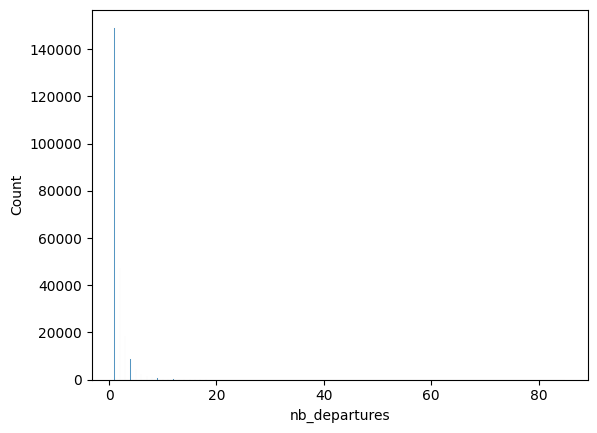

In [45]:
sns.histplot(df_dep_agg.nb_departures)

# Nb of arrivals

In [55]:
df_arrivals=df[["end_station_name",
                 "end_station_id",
                 "hourly_data_ended"]]

df_arrivals=df_arrivals.rename(columns={'hourly_data_ended':'hourly_data',
                                        "end_station_name":"station_name",
                                        "end_station_id": "station_id"
                                        })
df_arrivals["nb_arrivals"]=1
df_arrivals.head(2)

,station_name,station_id,hourly_data,nb_arrivals
0,Kingsbury St & Kinzie St,KA1503000043,2022-03-21 14:00:00,1
1,Orleans St & Chestnut St (NEXT Apts),620,2022-03-16 10:00:00,1


In [56]:
df_arr_agg=df_arrivals.groupby(by=["station_name",
                                        "station_id",
                                        'hourly_data']).count().reset_index()
df_arr_agg.head(10)

,station_name,station_id,hourly_data,nb_arrivals
0,2112 W Peterson Ave,KA1504000155,2022-01-01 07:00:00,1
1,2112 W Peterson Ave,KA1504000155,2022-01-03 02:00:00,1
2,2112 W Peterson Ave,KA1504000155,2022-01-03 06:00:00,1
3,2112 W Peterson Ave,KA1504000155,2022-01-03 15:00:00,1
4,2112 W Peterson Ave,KA1504000155,2022-01-03 18:00:00,1
5,2112 W Peterson Ave,KA1504000155,2022-01-04 01:00:00,1
6,2112 W Peterson Ave,KA1504000155,2022-01-04 06:00:00,1
7,2112 W Peterson Ave,KA1504000155,2022-01-08 01:00:00,1
8,2112 W Peterson Ave,KA1504000155,2022-01-09 20:00:00,1
9,2112 W Peterson Ave,KA1504000155,2022-01-13 01:00:00,1


In [57]:
df_arr_agg.nb_arrivals.value_counts()


1     146064
2      45684
3      18179
4       8444
5       4490
       ...  
62         1
51         1
55         1
41         1
40         1
Name: nb_arrivals, Length: 64, dtype: int64

In [58]:
merge_ratio=pd.merge(
df_dep_agg,
df_arr_agg,
how="outer",
on=['hourly_data',"station_name","station_id"])


merge_ratio["nb_departures"] = merge_ratio["nb_departures"].replace(np.nan, 0)
merge_ratio["nb_arrivals"] = merge_ratio["nb_arrivals"].replace(np.nan, 0)

merge_ratio['ratio']=merge_ratio['nb_departures']/merge_ratio['nb_arrivals']
merge_ratio.head(10)

,station_name,station_id,hourly_data,nb_departures,nb_arrivals,ratio
0,2112 W Peterson Ave,KA1504000155,2022-01-01 21:00:00,1.0,0.0,inf
1,2112 W Peterson Ave,KA1504000155,2022-01-03 18:00:00,1.0,1.0,1.0
2,2112 W Peterson Ave,KA1504000155,2022-01-04 11:00:00,1.0,0.0,inf
3,2112 W Peterson Ave,KA1504000155,2022-01-04 18:00:00,1.0,0.0,inf
4,2112 W Peterson Ave,KA1504000155,2022-01-10 09:00:00,1.0,0.0,inf
5,2112 W Peterson Ave,KA1504000155,2022-01-10 10:00:00,1.0,0.0,inf
6,2112 W Peterson Ave,KA1504000155,2022-01-12 16:00:00,1.0,0.0,inf
7,2112 W Peterson Ave,KA1504000155,2022-01-12 21:00:00,1.0,0.0,inf
8,2112 W Peterson Ave,KA1504000155,2022-01-13 16:00:00,1.0,1.0,1.0
9,2112 W Peterson Ave,KA1504000155,2022-01-13 18:00:00,1.0,1.0,1.0


In [59]:
merge_ratio.shape

(344946, 6)

In [12]:
def cleaning_divvy_gen(df):

    df['started_at']=pd.to_datetime(df['started_at'])
    df['ended_at']=pd.to_datetime(df['ended_at'])
    df['hourly_data_started'] = df.started_at.dt.round('60min')
    df['hourly_data_ended'] = df.ended_at.dt.round('60min')

    df_departures=df[[
                    "start_station_name",
                    "start_station_id",
                    "hourly_data_started"]]

    df_departures=df_departures.rename(columns={'hourly_data_started':'hourly_data',
                                                "start_station_name":"station_name",
                                                "start_station_id": "station_id"})

    df_departures["nb_departures"]=1
    
    df_dep_agg=df_departures.groupby(by=["station_name",
                                        "station_id",
                                        'hourly_data']).count().reset_index()
    
    
    df_arrivals=df[["end_station_name",
                 "end_station_id",
                 "hourly_data_ended"]]

    df_arrivals=df_arrivals.rename(columns={'hourly_data_ended':'hourly_data',
                                            "end_station_name":"station_name",
                                            "end_station_id": "station_id"})
    df_arrivals["nb_arrivals"]=1

    df_arr_agg=df_arrivals.groupby(by=["station_name",
                                            "station_id",
                                            'hourly_data']).count().reset_index()
    
    merge_ratio=pd.merge(
    df_dep_agg,
    df_arr_agg,
    how="outer",
    on=['hourly_data',"station_name","station_id"])


    merge_ratio["nb_departures"] = merge_ratio["nb_departures"].replace(np.nan, 0)
    merge_ratio["nb_arrivals"] = merge_ratio["nb_arrivals"].replace(np.nan, 0)

    merge_ratio['ratio']=merge_ratio['nb_departures']/merge_ratio['nb_arrivals']

    return merge_ratio    

In [13]:
test_divvy_df = cleaning_divvy_gen(df)
test_divvy_df.head(5)

,station_name,station_id,hourly_data,nb_departures,nb_arrivals,ratio
0,2112 W Peterson Ave,KA1504000155,2022-01-01 21:00:00,1.0,0.0,inf
1,2112 W Peterson Ave,KA1504000155,2022-01-03 18:00:00,1.0,1.0,1.0
2,2112 W Peterson Ave,KA1504000155,2022-01-04 11:00:00,1.0,0.0,inf
3,2112 W Peterson Ave,KA1504000155,2022-01-04 18:00:00,1.0,0.0,inf
4,2112 W Peterson Ave,KA1504000155,2022-01-10 09:00:00,1.0,0.0,inf


In [14]:
test_divvy_df.shape

(344946, 6)

# Merging this consolidated Divvy dataset with Weather data

## Importing and cleaning Weather data

In [15]:
raw_weather_df = get_weather_data()
clean_weather_df = weather_cleaning(raw_weather_df)


In [16]:
clean_weather_df.head(2)

,dt_iso,temp,pressure,humidity,wind_speed,wind_deg,clouds_all,hourly_data
0,2013-01-01 00:00:00,-2.87,1018,68,4.12,300,100,2013-01-01 00:00:00
1,2013-01-01 01:00:00,-3.12,1019,69,3.10,310,100,2013-01-01 01:00:00


## Merging Weather and Divvy data

In [17]:
merged_df = merge_divvy_weather(test_divvy_df, clean_weather_df)
merged_df.shape

(344946, 13)

In [18]:
merged_df.head(5)

,station_name,station_id,hourly_data,nb_departures,nb_arrivals,ratio,dt_iso,temp,pressure,humidity,wind_speed,wind_deg,clouds_all
0,2112 W Peterson Ave,KA1504000155,2022-01-01 21:00:00,1.0,0.0,inf,2022-01-01 21:00:00,-0.75,1010,93,4.92,20,100
1,2112 W Peterson Ave,KA1504000155,2022-01-03 18:00:00,1.0,1.0,1.0,2022-01-03 18:00:00,-6.55,1030,49,3.13,253,0
2,2112 W Peterson Ave,KA1504000155,2022-01-04 11:00:00,1.0,0.0,inf,2022-01-04 11:00:00,-5.02,1021,79,4.12,190,40
3,2112 W Peterson Ave,KA1504000155,2022-01-04 18:00:00,1.0,0.0,inf,2022-01-04 18:00:00,-0.39,1017,70,4.02,204,99
4,2112 W Peterson Ave,KA1504000155,2022-01-10 09:00:00,1.0,0.0,inf,2022-01-10 09:00:00,-10.37,1034,58,2.24,301,98


# Getting features and target dataset (target = nb_arrivals)

In [19]:
target ="nb_arrivals"

In [20]:
X,y = features_target(merged_df, target)

In [21]:
X.head(2)

,station_name,station_id,hourly_data,dt_iso,temp,pressure,humidity,wind_speed,wind_deg,clouds_all
0,2112 W Peterson Ave,KA1504000155,2022-01-01 21:00:00,2022-01-01 21:00:00,-0.75,1010,93,4.92,20,100
1,2112 W Peterson Ave,KA1504000155,2022-01-03 18:00:00,2022-01-03 18:00:00,-6.55,1030,49,3.13,253,0


In [22]:
y.head(2)

0    0.0
1    1.0
Name: nb_arrivals, dtype: float64

In [23]:
from ml_logic.data_import import get_station_data

In [28]:
station_df = get_station_data()

In [30]:
station_df_reduced  = station_df[["name","legacy_id","lat","lon"]]
station_df_reduced.rename(columns={"name":"station_name",
                                   "legacy_id":"station_id"
                                   
    }, inplace=True)
station_df_reduced.head(2)

/tmp/ipykernel_16004/4287912403.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_df_reduced.rename(columns={"name":"station_name",


,station_name,station_id,lat,lon
0,Central Ave & Harrison St,541,41.872993,-87.764499
1,Halsted St & 59th St,593,41.787539,-87.644874


In [32]:
X_complete = X.merge(station_df_reduced,how="left",on=["station_name","station_id"])
print(X.shape)
print(X_complete.shape)

(344946, 10)
(344946, 12)


In [43]:
X_complete.head(2)

,station_name,station_id,hourly_data,dt_iso,temp,pressure,humidity,wind_speed,wind_deg,clouds_all,lat,lon
0,2112 W Peterson Ave,KA1504000155,2022-01-01 21:00:00,2022-01-01 21:00:00,-0.75,1010,93,4.92,20,100,NaN,NaN
1,2112 W Peterson Ave,KA1504000155,2022-01-03 18:00:00,2022-01-03 18:00:00,-6.55,1030,49,3.13,253,0,NaN,NaN


In [44]:
from ml_logic.data_import import get_station_data

def features_target(df, target):
    '''
    This function creates the features and target dataframes, the latter
    being created by identifying the target (nb_departures, nb_arrivals, ratio of the two)
    as an argument
    '''
                                    
    features_df = df.drop(columns=["ratio","nb_departures","nb_arrivals"])
    target_df =  df[target]

    return features_df, target_df


In [34]:
features_df_complete, target_df = features_target(merged_df,target)

/tmp/ipykernel_16004/2695826693.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_df_reduced.rename(columns={"name":"station_name",


In [35]:
features_df_complete.head(2)

,station_name,station_id,hourly_data,dt_iso,temp,pressure,humidity,wind_speed,wind_deg,clouds_all,lat,lon
0,2112 W Peterson Ave,KA1504000155,2022-01-01 21:00:00,2022-01-01 21:00:00,-0.75,1010,93,4.92,20,100,NaN,NaN
1,2112 W Peterson Ave,KA1504000155,2022-01-03 18:00:00,2022-01-03 18:00:00,-6.55,1030,49,3.13,253,0,NaN,NaN


In [36]:
target_df.head(2)

0    0.0
1    1.0
Name: nb_arrivals, dtype: float64

# Formatting features and target for RNN purposes

In [22]:
list_stations = list(X.station_id.unique())
print(len(list_stations))
list_stations[0:5]

847


['KA1504000155', '15491', '13028', '13157', '13156']

In [23]:
i = list_stations[0]
i

'KA1504000155'

In [24]:
obs_ = X[X["station_id"]==i]


In [25]:
obs_ = obs_.reset_index()

In [26]:
obs_.shape

(149, 11)

In [27]:
obs_.index

RangeIndex(start=0, stop=149, step=1)

In [28]:
len(obs_)
obs_.loc[72,:]

index                            72
station_name    2112 W Peterson Ave
station_id             KA1504000155
hourly_data     2022-03-31 03:00:00
dt_iso          2022-03-31 03:00:00
temp                          13.89
pressure                        988
humidity                         95
wind_speed                     3.37
wind_deg                        152
clouds_all                      100
Name: 72, dtype: object

In [32]:
list_obs_station = []
for j in range(0,len(obs_)):
    
    liste=np.array(obs_.loc[j])
    
    list_obs_station.append(liste)

In [33]:
list_obs_station[0]

array([0, '2112 W Peterson Ave', 'KA1504000155',
       Timestamp('2022-01-01 21:00:00'), Timestamp('2022-01-01 21:00:00'),
       -0.75, 1010, 93, 4.92, 20, 100], dtype=object)

In [39]:
array_test = np.array(list_obs_station[0])

for i in range(1,len(list_obs_station)):
    array_test= np.append(array_test,list_obs_station[i])

In [41]:
array_test.shape

(1639,)

In [143]:
list_stations = list(X.station_id.unique())

Sequence_of_stations = []

for i in list_stations:

    obs_station = X[X["station_id"]==i]
    obs_station = obs_station.reset_index()

    list_obs_station = []

    for j in range(0,len(obs_station)):
        
        liste=list(obs_station.loc[j])
        
        list_obs_station.append(liste)
        
    Sequence_of_stations.append(list_obs_station)
        

In [155]:
len(Sequence_of_stations[0][0])

11

In [153]:
X_formated = np.array([Sequence_of_stations])
X_formated.shape

/tmp/ipykernel_10666/97222989.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_formated = np.array([Sequence_of_stations])


(1, 847)

# Encoding of station_name

In [76]:
from sklearn.preprocessing import OneHotEncoder

In [77]:
X.station_name.nunique()

847

In [81]:
ohe = OneHotEncoder(sparse = False)
ohe.fit(X[['station_name']])

OneHotEncoder(sparse=False)

In [82]:
X_encoded = ohe.transform(X[["station_name"]])

In [83]:
X[ohe.categories_[0]] = X_encoded

In [84]:
X = X.drop("station_name", axis=1)

In [85]:
X.shape

(344946, 856)

In [ ]:
time_categories = {
                    0: np.arange(0, 7, 1),  # days of the week
                    1: np.arange(1, 13, 1)  # months of the year
                    # will need to add one cat for the year when generalizing
                }

time_pipe = make_pipeline(
    FunctionTransformer(transform_time_features),
    make_column_transformer(
        (OneHotEncoder(
            categories=time_categories,
            sparse=False,
            handle_unknown="ignore"), [2,3]), # correspond to columns ["day of week", "month"], not the others columns
        #(FunctionTransformer(lambda year: (year-year_min)/(year_max-year_min)), [4]), # min-max scale the columns 4 ["year"]
        remainder="passthrough" # keep hour_sin and hour_cos
        )
    )

weather_pipe = make_pipeline(StandardScaler())
weather_features = ["temp","pressure","humidity","wind_speed","wind_deg","clouds_all"]


cat_transformer = OneHotEncoder(sparse_output=False)

final_preprocessor = ColumnTransformer(
        [
            ("time_preproc", time_pipe, ["hourly_data"]),
            ("weather_scaler",weather_pipe, weather_features),
            ("geohash encoding", cat_transformer,["geohash"])
        ],
        n_jobs=-1,
    )

In [45]:
features_df_complete, target_df = features_target(merged_df,target)

In [46]:
features_df_complete.head(2)

,station_name,station_id,hourly_data,dt_iso,temp,pressure,humidity,wind_speed,wind_deg,clouds_all
0,2112 W Peterson Ave,KA1504000155,2022-01-01 21:00:00,2022-01-01 21:00:00,-0.75,1010,93,4.92,20,100
1,2112 W Peterson Ave,KA1504000155,2022-01-03 18:00:00,2022-01-03 18:00:00,-6.55,1030,49,3.13,253,0


In [47]:
features_df_complete.shape

(344946, 10)

In [60]:
import pygeohash as gh
from ml_logic.data_import import get_station_data


def compute_geohash_stations(precision: int = 5) -> np.ndarray:
    """
    Add a geohash (ex: “dr5rx”) of len “precision” = 5 by default
    corresponding to each (lon,lat) tuple, for pick-up, and drop-off
    """
            
    df_stations=get_station_data()
    assert isinstance(df_stations, pd.DataFrame)
    df_stations["geohash"] = df_stations.apply(lambda x: gh.encode(
        x.lat, x.lon, precision=precision),
                                    axis=1)
    df_stations_reduced=df_stations[["name","geohash"]]
    df_stations_reduced.rename(columns={"name":"station_name"}, inplace=True)
    return df_stations_reduced


In [61]:
# Calling Geohash function and creating Stations Dataframe
df_stations_reduced=compute_geohash_stations(precision=5)


/tmp/ipykernel_16004/110657374.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stations_reduced.rename(columns={"name":"station_name"}, inplace=True)


In [62]:
df_stations_reduced.geohash.nunique()

47

In [59]:
df_stations_reduced[df_stations_reduced["station_name"]=="2112 W Peterson Ave"]

,station_name,station_id,geohash
224,2112 W Peterson Ave,456,dp3wu


In [124]:
df_stations_reduced.head(5)

,station_name,geohash
0,Central Ave & Harrison St,dp3w4
1,Halsted St & 59th St,dp3tt
2,Damen Ave & 51st St,dp3tu
3,Halsted St & 21st St,dp3wj
4,Michigan Ave & Madison St,dp3wq


In [63]:
# Merge divvy data & station data
X_complete=features_df_complete.merge(df_stations_reduced,how="left",on=["station_name"])
X_complete.head(5)

,station_name,station_id,hourly_data,dt_iso,temp,pressure,humidity,wind_speed,wind_deg,clouds_all,geohash
0,2112 W Peterson Ave,KA1504000155,2022-01-01 21:00:00,2022-01-01 21:00:00,-0.75,1010,93,4.92,20,100,dp3wu
1,2112 W Peterson Ave,KA1504000155,2022-01-03 18:00:00,2022-01-03 18:00:00,-6.55,1030,49,3.13,253,0,dp3wu
2,2112 W Peterson Ave,KA1504000155,2022-01-04 11:00:00,2022-01-04 11:00:00,-5.02,1021,79,4.12,190,40,dp3wu
3,2112 W Peterson Ave,KA1504000155,2022-01-04 18:00:00,2022-01-04 18:00:00,-0.39,1017,70,4.02,204,99,dp3wu
4,2112 W Peterson Ave,KA1504000155,2022-01-10 09:00:00,2022-01-10 09:00:00,-10.37,1034,58,2.24,301,98,dp3wu


In [69]:
X_complete = X_complete.drop(columns=["station_name","station_id","dt_iso"])

In [70]:
time_categories = {
                    0: np.arange(0, 7, 1),  # days of the week
                    1: np.arange(1, 13, 1)  # months of the year
                    # will need to add one cat for the year when generalizing
                }

time_pipe = make_pipeline(
    FunctionTransformer(transform_time_features),
    make_column_transformer(
        (OneHotEncoder(
            categories=time_categories,
            sparse=False,
            handle_unknown="ignore"), [2,3]), # correspond to columns ["day of week", "month"], not the others columns
        #(FunctionTransformer(lambda year: (year-year_min)/(year_max-year_min)), [4]), # min-max scale the columns 4 ["year"]
        remainder="passthrough" # keep hour_sin and hour_cos
        )
    )

weather_pipe = make_pipeline(StandardScaler())
weather_features = ["temp","pressure","humidity","wind_speed","wind_deg","clouds_all"]


cat_transformer = OneHotEncoder(sparse=False)

final_preprocessor = ColumnTransformer(
        [
            ("time_preproc", time_pipe, ["hourly_data"]),
            ("weather_scaler",weather_pipe, weather_features),
            ("geohash encoding", cat_transformer,["geohash"])
        ],
        n_jobs=-1,
    )

In [71]:
X_processed = final_preprocessor.fit_transform(X_complete)

X_processed_df = pd.DataFrame(X_processed)

In [72]:
X_processed_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [125]:
import os
import pandas as pd
import numpy as np
import math

from ml_logic.data_import import get_weather_data, get_divvy_data
from ml_logic.cleaning import weather_cleaning, cleaning_divvy_gen, merge_divvy_weather, features_target
from ml_logic.preprocessor import transform_time_features, preprocess_features, target_process, compute_geohash_stations


from ml_logic.main import preprocess, preprocess_test

In [117]:
X_processed_df, y_processed_df, preprocessor, df_stations_reduced = preprocess("nb_arrivals")
X_test_processed, y_test_processed=preprocess_test(preprocessor, "nb_arrivals", df_stations_reduced)

Raw data imported
Data cleaned and merged
features and target dataframes created
Geohash of stations computed
Geohash of stations added to Features dataframe


/home/gdolle/code/G-Dolle/DIVVY_BIKE/ml_logic/preprocessor.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stations_reduced.rename(columns={"name":"station_name"}, inplace=True)


features preprocessed
nb_arrivals picked as target
Preprocessing of Training set is done


In [118]:
X_processed_df.shape

(344946, 74)

In [119]:
X_processed_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [120]:
X_test_processed, y_test_processed=preprocess_test(preprocessor, "nb_arrivals", df_stations_reduced)

Test Raw data imported
Test Data cleaned and merged
Test features and target dataframes created
nb_arrivals picked as target
Preprocessing of test set is done


In [121]:
X_test_processed.shape

(659944, 74)

In [123]:
pd.DataFrame(X_test_processed).head(2)

,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
quarter= os.environ.get("DIVVY_QUARTER_TEST")
year= os.environ.get("DIVVY_YEAR_TEST")

raw_divvy_df = get_divvy_data(year,quarter)
raw_weather_df = get_weather_data()


In [102]:
clean_divvy_df = cleaning_divvy_gen(raw_divvy_df)
clean_weather_df = weather_cleaning(raw_weather_df)

merged_df_test = merge_divvy_weather(clean_divvy_df, clean_weather_df)

In [103]:
X_test, y_test = features_target(merged_df_test, "nb_arrivals")

In [104]:
X_complete=X_test.merge(df_stations_reduced,how="left",on=["station_name"])

In [105]:
X_complete.head(2)

,station_name,station_id,hourly_data,dt_iso,temp,pressure,humidity,wind_speed,wind_deg,clouds_all,geohash
0,111th St - Morgan Park Metra,682,2022-05-09 17:00:00,2022-05-09 17:00:00,23.11,1013,51,7.72,160,75,NaN
1,111th St - Morgan Park Metra,682,2022-05-12 18:00:00,2022-05-12 18:00:00,32.62,1018,43,7.72,170,20,NaN


In [107]:
X_complete.geohash.unique()

array([nan, 'dp3wu', 'dp3tx', 'dp3wj', 'dp3wm', 'dp3tj', 'dp3wn', 'dp3wh',
       'dp3ws', 'dp3wk', 'dp3sy', 'dp3tu', 'dp3tv', 'dp3tt', 'dp3wt',
       'dp3w7', 'dp3w6', 'dp3v0', 'dp3sz', 'dp3we', 'dp3tr', 'dp3xh',
       'dp3tp', 'dp3ty', 'dp3w3', 'dp3xj', 'dp3wv', 'dp3v2', 'dp3ts',
       'dp3tw', 'dp3w4', 'dp3wd', 'dp3w5', 'dp3xk', 'dp3tq', 'dp3wq',
       'dp3tn', 'dp3tm', 'dp3te', 'dp3w9', 'dp3th', 'dp3tg', 'dp3x7',
       'dp3tz', 'dp3wg', 'dp3t7', 'dp3tk'], dtype=object)

In [108]:
X_complete.geohash.replace(np.nan, "aaa", inplace=True)

In [109]:
X_complete.geohash.unique()

array(['aaa', 'dp3wu', 'dp3tx', 'dp3wj', 'dp3wm', 'dp3tj', 'dp3wn',
       'dp3wh', 'dp3ws', 'dp3wk', 'dp3sy', 'dp3tu', 'dp3tv', 'dp3tt',
       'dp3wt', 'dp3w7', 'dp3w6', 'dp3v0', 'dp3sz', 'dp3we', 'dp3tr',
       'dp3xh', 'dp3tp', 'dp3ty', 'dp3w3', 'dp3xj', 'dp3wv', 'dp3v2',
       'dp3ts', 'dp3tw', 'dp3w4', 'dp3wd', 'dp3w5', 'dp3xk', 'dp3tq',
       'dp3wq', 'dp3tn', 'dp3tm', 'dp3te', 'dp3w9', 'dp3th', 'dp3tg',
       'dp3x7', 'dp3tz', 'dp3wg', 'dp3t7', 'dp3tk'], dtype=object)

In [106]:
df_stations_reduced[df_stations_reduced["station_name"]=="111th St - Morgan Park Metra"]

,station_name,geohash


In [115]:
X_test_processed = preprocessor.transform(X_complete)

In [2]:
pwd

'/home/gdolle/code/G-Dolle/DIVVY_BIKE/notebooks'

In [3]:
cd '/home/gdolle/code/G-Dolle/DIVVY_BIKE'

/home/gdolle/code/G-Dolle/DIVVY_BIKE


In [4]:
import os
import pandas as pd
import numpy as np
import math

from ml_logic.data_import import get_weather_data, get_divvy_data
from ml_logic.cleaning import weather_cleaning, cleaning_divvy_gen, merge_divvy_weather, features_target
from ml_logic.preprocessor import transform_time_features, preprocess_features, target_process, compute_geohash_stations


from ml_logic.main import preprocess, preprocess_test

In [6]:
X_processed_df, y_processed_df, preprocessor, df_stations_reduced = preprocess("nb_arrivals")

Raw data imported
Data cleaned and merged
features and target dataframes created
Geohash of stations computed
Geohash of stations added to Features dataframe


/home/gdolle/code/G-Dolle/DIVVY_BIKE/ml_logic/preprocessor.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stations_reduced.rename(columns={"name":"station_name"}, inplace=True)


features preprocessed
nb_arrivals picked as target
Preprocessing of Training set is done


In [7]:
X_processed_df.shape

(718651, 72)

In [8]:
X_test_processed, y_test_processed=preprocess_test(preprocessor, "nb_arrivals", df_stations_reduced)

Test Raw data imported
Test Data cleaned and merged
Test features and target dataframes created
nb_arrivals picked as target
Preprocessing of test set is done


In [9]:
X_test_processed.shape

(539439, 72)